In [1]:
import os, csv, json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# CPFA Hypertune Study - Final Analysis

### Data Ingest

In [2]:
filenames = [f for f in os.listdir('../../data/raw') if f[-4:] == 'json']
filenames

['db_backup3.json', 'db_backup.json', 'db_backup2.json']

###### trials to keep:
cpfa_ht_trial_20191111_081725
cpfa_ht_trial_20191111_080838
cpfa_ht_trial_20191111_080831

In [3]:
results = {}
keeper_trials = {'cpfa_ht_trial_20191111_081725': [], 
                 'cpfa_ht_trial_20191111_080838': [], 
                 'cpfa_ht_trial_20191111_080831': []}

for trial in keeper_trials:
    for i in range(3001):
        keeper_trials[trial].append({})

sample object:
```{"logName":"projects/cpfa-hypertune/logs/master-replica-0","resource":{"type":"ml_job","labels":{"job_id":"cpfa_ht_trial_20191110_115124","project_id":"cpfa-hypertune","task_name":"master-replica-0"}},"jsonPayload":{"message":"food distribution 0\n","levelname":"INFO"},"timestamp":"2019-11-10 22:52:31.313637 UTC","receiveTimestamp":"2019-11-10 22:52:35.761271 UTC","severity":"INFO","insertId":"5u96i6fa2o7si","labels":{"compute_googleapis_com_resource_id":"3176392964891290663","compute_googleapis_com_zone":"us-central1-a","ml_googleapis_com_trial_id":"336","compute_googleapis_com_resource_name":"cmle-training-805699422387418271","ml_googleapis_com_job_id_log_area":"root"}}```

In [4]:
trialcount = 0;
rowsList = []
trials = []
for file in filenames:
    with open(os.path.join('../../data/raw', file)) as json_file:
        for i, line in enumerate(json_file):
            x = json.loads(line)
            job_id = x['resource']['labels']['job_id']
            trialId = int(x['labels']['ml_googleapis_com_trial_id'])
            message = x['jsonPayload']['message']
            if job_id in keeper_trials:
                if 'trialId' not in keeper_trials[job_id][trialId]:
                    keeper_trials[job_id][trialId]['trialId'] = trialId
                if 'Fitness Score' in message:
                    keeper_trials[job_id][trialId]['fitnessScore'] = float(message.split()[3])
                if 'foodDist' not in keeper_trials[job_id][trialId] and 'food' in message:
                    keeper_trials[job_id][trialId]['foodDist'] = float(message.split()[2])
                if 'Fitness' in message:
                    keeper_trials[job_id][trialId]['fitness'] = float(message.split()[3])
                if 'RateOfLayingPheromone' in message:
                    keeper_trials[job_id][trialId]['RateOfLayingPheromone'] = float(message.split()[1])
                if 'ProbabilityOfSwitchingToSearching' in message:
                    keeper_trials[job_id][trialId]['ProbabilityOfSwitchingToSearching'] = float(message.split()[1])
                if 'ProbabilityOfReturningToNest' in message:
                    keeper_trials[job_id][trialId]['ProbabilityOfReturningToNest'] = float(message.split()[1])
                if 'RateOfInformedSearchDecay' in message:
                    keeper_trials[job_id][trialId]['RateOfInformedSearchDecay'] = float(message.split()[1])
                if ('RateOfSiteFidelity' in message):
                    keeper_trials[job_id][trialId]['RateOfSiteFidelity'] = float(message.split()[1])
                if ('RateOfPheromoneDecay' in message):
                    keeper_trials[job_id][trialId]['RateOfPheromoneDecay'] = float(message.split()[1])
                if ('UninformedSearchVariation' in message):
                    keeper_trials[job_id][trialId]['UninformedSearchVariation'] = float(message.split()[1])
            else:
                pass

### Write trials to CSV

In [5]:
for trial in keeper_trials:
    df = pd.DataFrame(keeper_trials[trial])
    print(len(df.dropna()))
    df.dropna().sort_values(by=['fitnessScore'], ascending=True).to_csv('{}.csv'.format(trial))

2973
2968
2983


In [6]:
df[df['dist'] == 0].sort_values(by=['score'], ascending=False)

KeyError: 'dist'

### Analysis

In [8]:
df = pd.read_csv('../../data/parsed/docker_output_all.csv', skipinitialspace=True)

In [9]:
df['dist']

0      0
1      0
2      0
3      0
4      0
      ..
295    2
296    2
297    2
298    2
299    2
Name: dist, Length: 300, dtype: int64

In [10]:
trial_ga_d0 = df[(df['method'] == 'ga') & (df['dist'] == 0)]['score']
trial_ga_d1 = df[(df['method'] == 'ga') & (df['dist'] == 1)]['score']
trial_ga_d2 = df[(df['method'] == 'ga') & (df['dist'] == 2)]['score']

trial_ht_d0 = df[(df['method'] == 'ht') & (df['dist'] == 0)]['score']
trial_ht_d1 = df[(df['method'] == 'ht') & (df['dist'] == 1)]['score']
trial_ht_d2 = df[(df['method'] == 'ht') & (df['dist'] == 2)]['score']

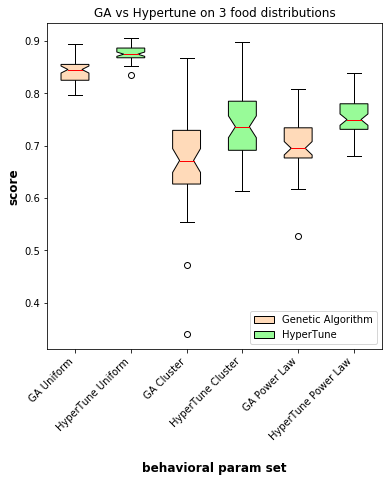

In [11]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
meanlineprops = dict(linewidth=1, color='red')
box_colors = ['darkkhaki', 'royalblue']
ax1.set_title('GA vs Hypertune on 3 food distributions')
plt.xlabel('behavioral param set', fontweight='bold', fontsize=12, labelpad=20,)
plt.ylabel('score', fontweight='bold', fontsize=12)
boxplots = ax1.boxplot([trial_ga_d0, trial_ht_d0, trial_ga_d1, trial_ht_d1, trial_ga_d2, trial_ht_d2], 
                       patch_artist=True, notch=True, medianprops=meanlineprops)
ax1.set_xticklabels(np.repeat(["GA Uniform", "HyperTune Uniform", "GA Cluster", "HyperTune Cluster", "GA Power Law", "HyperTune Power Law"], 1),rotation=45, fontsize=10, ha="right")

colors = ['peachpuff', 'palegreen']



# for patch, color in zip(axes['boxes'], colors):
for index, patch in enumerate(boxplots['boxes']):
    patch.set_label('hi')
    patch.set_facecolor(colors[index % 2])

ax1.legend([boxplots["boxes"][0], boxplots["boxes"][1]], ['Genetic Algorithm', 'HyperTune'], loc='lower right')

